In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms

# CIFAR-10 데이터셋에 대한 전처리 설정
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 training dataset 불러오기
train_dataset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

# CIFAR-10 test dataset 불러오기
test_dataset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

# CIFAR-10 데이터셋으로부터 클래스 레이블 가져오기
class_labels = train_dataset.classes

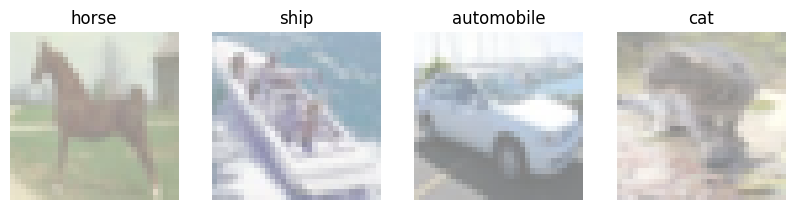

In [2]:
def imshow(images, labels):
    batch_size = images.shape[0]
    
    fig, axarr = plt.subplots(1, batch_size, figsize=(10, 4))
    
    for i in range(batch_size):
        img = images[i] / 2 + 0.5  # 정규화 복원
        npimg = img.numpy()
        axarr[i].imshow(np.transpose(npimg, (1, 2, 0)))
        axarr[i].set_title(class_labels[labels[i].item()])
        axarr[i].axis('off')

    plt.show()

# 학습 데이터의 일부를 가져옴
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
images, labels = next(iter(dataloader))

# 이미지와 레이블을 함께 출력
imshow(images, labels)

In [3]:
# 필요한 라이브러리 불러오기
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm.auto import tqdm

# 간단한 CNN 모델 정의하기
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # 3개의 입력 채널, 32개의 출력 채널, 3x3 커널 크기, 패딩=1
        self.relu1 = nn.ReLU()  # ReLU 활성화 함수
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 32개의 입력 채널, 64개의 출력 채널, 3x3 커널 크기, 패딩=1
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 커널 크기와 2의 스트라이드를 사용하는 Max Pooling
        self.flatten = nn.Flatten()  # 완전 연결 계층(FC Layer)을 통과하기 위한 텐서 평탄화
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # 64x8x8의 입력 특성, 512개의 출력 특성을 가지는 완전 연결층

        # 64: 두 번째 합성곱 레이어에서 출력된 채널 수입니다. 즉, 각 위치에서 64개의 특성 맵이 생성되었습니다.
        # 8x8: 두 번째 합성곱 레이어의 출력 특성맵의 공간 크기입니다. 이는 입력 이미지의 공간 해상도가 합성곱과 풀링 연산을 거치면서 감소한 결과입니다.

        self.relu3 = nn.ReLU()  # ReLU 활성화 함수
        self.fc2 = nn.Linear(512, 10)  # 512개의 입력 특성, 10개(레이블 개수) 출력 특성을 가지는 완전 연결층

    def forward(self, x):
        x = self.conv1(x)  # 입력: (N, 3, 32, 32), 출력: (N, 32, 32, 32) N은 배치 사이즈
        x = self.relu1(x)
        x = self.pool(x)  # 입력: (N, 32, 32, 32), 출력: (N, 32, 16, 16)
        x = self.conv2(x)  # 입력: (N, 32, 16, 16), 출력: (N, 64, 16, 16)
        x = self.relu2(x)
        x = self.pool(x)  # 입력: (N, 64, 16, 16), 출력: (N, 64, 8, 8)
        x = self.flatten(x)  # 2D 텐서로 평탄화, 입력: (N, 64, 8, 8), 출력: (N, 64*8*8)
        x = self.fc1(x)  # 입력: (N, 64*8*8), 출력: (N, 512)
        x = self.relu3(x)
        x = self.fc2(x)  # 입력: (N, 512), 출력: (N, 10)
        return x

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# CNN 모델의 인스턴스 생성
model = CNN()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
# 훈련 루프
num_epochs = 10
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 99:
            print(f'Epoch {epoch+1}, Batch {i+1}/{len(train_dataloader)}, Loss: {running_loss/100:.4f}')
            running_loss = 0.0
            

Epoch 1, Batch 100/782, Loss: 1.9194
Epoch 1, Batch 200/782, Loss: 1.6303
Epoch 1, Batch 300/782, Loss: 1.5112
Epoch 1, Batch 400/782, Loss: 1.4080
Epoch 1, Batch 500/782, Loss: 1.3072
Epoch 1, Batch 600/782, Loss: 1.2957
Epoch 1, Batch 700/782, Loss: 1.2373
Epoch 2, Batch 100/782, Loss: 1.1214
Epoch 2, Batch 200/782, Loss: 1.1357
Epoch 2, Batch 300/782, Loss: 1.0802
Epoch 2, Batch 400/782, Loss: 1.0726
Epoch 2, Batch 500/782, Loss: 1.0109
Epoch 2, Batch 600/782, Loss: 1.0246
Epoch 2, Batch 700/782, Loss: 0.9959
Epoch 3, Batch 100/782, Loss: 0.9177


KeyboardInterrupt: 

In [ ]:
# 테스트 루프
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
total_correct = 0
total_samples = 0

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

accuracy = 100 * total_correct / total_samples
print(f'Test Accuracy: {accuracy:.2f}%')

>>> Test Accuracy: 71.39%

Test Accuracy: 72.36%
